<a href="https://colab.research.google.com/github/JalalSayed1/AI-Coursework/blob/master/opt_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, we are going to implement see if we can optimally select a subset of training instances for supervised learning.

In [1]:
pip install -U scikit-learn scipy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-11-13 10:37:56.963707: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 10:37:56.965291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 10:37:56.997946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 10:37:56.997991: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 10:37:56.998012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

We are going to work with the MNIST dataset, a popular dataset for hand-written digit recognition. Here we load the datatset.

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1) # 28x28 pixel images with 1 colour channel (grayscale)

# Load the data and split it between train and test sets
# x = images, y = labels
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 # 0-255 to 0-1
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # -1 means last dimension
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("Loaded {} train samples".format(x_train.shape[0]))
print("Loaded {} test samples".format(x_test.shape[0]))

x_train shape: (60000, 28, 28, 1)
Loaded 60000 train samples
Loaded 10000 test samples


Now corrupt the labels with common types of mistakes. The variable 'noise_probability' controls the amount of errors introduced.

In [4]:
import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0:
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        # generate a random number between 0 and 1:
        p = random.random()

        #! if p > noise_probability, then we do not corrupt the label?
        if p < noise_probability:
            y = y_train[i]
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))


Corruptions: {'5->9': 649, '0->2': 708, '4->2': 566, '1->9': 654, '9->2': 691, '1->2': 652, '4->6': 590, '3->5': 717, '5->2': 612, '3->2': 712, '7->0': 642, '2->0': 695, '6->2': 697, '9->5': 715, '4->9': 591, '0->9': 678, '1->6': 719, '2->5': 687, '3->8': 756, '2->8': 670, '7->9': 588, '9->8': 689, '0->6': 660, '5->0': 621, '7->6': 645, '1->0': 741, '8->2': 698, '9->0': 724, '8->3': 688, '5->8': 661, '4->5': 587, '8->9': 709, '1->5': 605, '6->0': 696, '6->8': 669, '6->3': 709, '8->0': 695, '9->6': 666, '7->3': 649, '3->9': 686, '1->8': 696, '1->3': 637, '0->3': 688, '2->3': 712, '3->6': 706, '0->8': 690, '0->5': 719, '7->8': 605, '9->3': 676, '6->9': 658, '6->5': 672, '3->0': 705, '7->5': 639, '4->3': 604, '5->6': 651, '8->5': 692, '2->6': 684, '2->9': 731, '4->8': 553, '7->2': 631, '4->0': 584, '5->3': 613, '8->6': 658}
Corrupted indexes: [0, 1, 2, 3, 4, 6, 9, 10, 11, 12]


In [5]:
# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

Supervised (parametric) training with the (noisy) labeled examples. Note that this model is trained on the entire dataset (the value of the parameter pruned_indexes is null here, which means that we leave out no points), which is noisy (20% of the labels are corrupted). Now the question is: is this the best model that we can train or can we do better?

In [6]:
batch_size = 128
epochs = 3 # very high epochs might overfit the model.
validation_split=0.1


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

def prune_points(x_train, y_train, pruned_indexes):
    num_samples = x_train.shape[0] # = 60000
    x_train_pruned = []
    y_train_pruned = []
    for i in range(num_samples):
        if not i in pruned_indexes:
            x_train_pruned.append(x_train[i])
            y_train_pruned.append(y_train[i])

    return np.array(x_train_pruned), np.array(y_train_pruned)

def trainAndEvaluateModel(x_train, y_train, x_test, y_test, model, pruned_indexes):

    if not pruned_indexes == None:
        x_train_pruned, y_train_pruned = prune_points(x_train, y_train, pruned_indexes)
    else:
        x_train_pruned = x_train
        y_train_pruned = y_train

    # start training the model:
    model.fit(x_train_pruned, y_train_pruned, batch_size=batch_size, epochs=epochs)
    model.evaluate(x_test, y_test)
    keras.backend.clear_session() # remove previous training weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dropout (Dropout)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

And we call the following function to train a model on the entire dataset and evaluate it on the test set. The accuracy on the test set is quite good, but can we do better?

In [7]:
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, None)

Epoch 1/3
469/469 [==============================] - 6s 12ms/step - loss: 1.9959 - accuracy: 0.2444
Epoch 2/3
469/469 [==============================] - 5s 12ms/step - loss: 1.9512 - accuracy: 0.2701
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 1.4034 - accuracy: 0.8968


You need to implement a subset selection function that when called will return a subset of instances which will be used to train the model. This setup ensures that you also pass in another dictionary which contains the indexes of the instances that you would not want to use while training the model, i.e., it should contain a list of indexes that you would decide to **leave out** for training.

Here's the code and a sample implementation that returns a randomly chosen set of instances that you are to be left out. Since we chose 70% probability of label corruption (check the **noise_probability** parameter), we also select a subset where we leave out the same proportion of points. This is a baseline implementation and obviously you should aim to achieve better results than this.

In [8]:
# Here 'x_train', 'y_train' and model' are an unused parameters. But you may get better results by leveraging these.
def baseLinePrunedSubsetMethod(x_train, y_train, model):
    pruned_indexes = {}
    num_samples = x_train.shape[0]
    for i in range(num_samples):
        p = random.random()

        if p < noise_probability: # this is the global variable (only useful for this naive approach)
            pruned_indexes[i] = i
    return pruned_indexes

Let's see how this naive baseline works.

In [9]:
pruned_indexes = baseLinePrunedSubsetMethod(x_train, y_train, model)
# print (f"pruned_indexes: {pruned_indexes}")
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)

Epoch 1/3
140/140 [==============================] - 2s 12ms/step - loss: 1.9315 - accuracy: 0.2803
Epoch 2/3
140/140 [==============================] - 2s 13ms/step - loss: 1.9208 - accuracy: 0.2822
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 1.3795 - accuracy: 0.8929


Let's now see if we had known what points were actually corrupted (more of a hypothetical unrealistic situation), does leaving out those points actually improve the model's effectiveness. It turns out that it does!

In [10]:

#! This keeps going up and up: bc we keep training the model on the same data. 
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, corrupted_indexes)

Epoch 1/3
141/141 [==============================] - 2s 12ms/step - loss: 0.3609 - accuracy: 0.9218
Epoch 2/3
141/141 [==============================] - 2s 13ms/step - loss: 0.1784 - accuracy: 0.9492
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1217 - accuracy: 0.9647


Your task is to implement your own version of (say of name **myPrunedSubsetMethod** (which should take as arguments x_train, y_train, and the model). The function should return a dictionary of indexes that are to be left out. Plug your function in and evaluate the results. Write a thorough report on the methodology and analyse the results.

Some hints:
You can approach this as a discrete state space optimisation problem, where firstly you can define a "selection batch size" (this is not the same as training batch size), which decides which batch of instances you're going to leave out. For instance, if you are in a state where the training set is $X$, you may select (by some heuristics) which points you're gonna leave out (let that set be $\delta \subset X$) so that a child state becomes $X' = X - \delta$. Similarly, if you choose a different $\delta$ you get a different child state. You then need to train and evaluate (call the function *trainAndEvaluateModel*) to see if that child state led to an improvement or not.

You are free to use any algorithm, e.g., simulated annealing, A* search, genetic algorithm etc. to implement this discrete state space optimisation.

In [1]:
loss_list = []
acc_list = []

In [2]:

#! remove this:
from sklearn.metrics import accuracy_score

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1) # 28x28 pixel images with 1 colour channel (grayscale)

# Load the data and split it between train and test sets
# x = images, y = labels
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 # 0-255 to 0-1
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # -1 means last dimension
x_test = np.expand_dims(x_test, -1)

import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0: #! if y (true label if is in err)
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y #! if y is not in err, then return y (true label) then use error set 2

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        # generate a random number between 0 and 1:
        p = random.random()

        #! if p > noise_probability, then we do not corrupt the label?
        if p < noise_probability:
            y = y_train[i] # true label
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))

# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)



batch_size = 128
epochs = 3 # very high epochs might overfit the model.
validation_split=0.1


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

def prune_points(x_train, y_train, pruned_indexes):
    num_samples = x_train.shape[0] # = 60000
    x_train_pruned = []
    y_train_pruned = []
    for i in range(num_samples):
        if not i in pruned_indexes:
            x_train_pruned.append(x_train[i])
            y_train_pruned.append(y_train[i])

    return np.array(x_train_pruned), np.array(y_train_pruned)

def trainAndEvaluateModel(x_train, y_train, x_test, y_test, model, pruned_indexes):

    if not pruned_indexes == None:
        x_train_pruned, y_train_pruned = prune_points(x_train, y_train, pruned_indexes)
    else:
        x_train_pruned = x_train
        y_train_pruned = y_train

    # start training the model:
    model.fit(x_train_pruned, y_train_pruned, batch_size=batch_size, epochs=epochs)
    
    #! remove this:
    y_prob = model.predict(x_test)  # Get predictions
    y_pred = np.argmax(y_prob, axis=1)  # Convert to class labels
    # If y_test is one-hot encoded, convert it back to labels
    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, y_pred)
    print(f"Accuracy: {accuracy}")
    
    #! if my algorithm must use the loss or accuracy, then I can mention in the report:
    loss, accuracy = model.evaluate(x_test, y_test)
    # loss_list.append(loss) #! remove this
    # acc_list.append(accuracy) #! remove this
    #! ------------------------

    keras.backend.clear_session() # remove previous training weights

    #! remove this:    
    return loss, accuracy


2023-11-13 22:06:32.077875: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 22:06:32.080922: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 22:06:32.119791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 22:06:32.119844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 22:06:32.119863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Corruptions: {'5->3': 632, '9->0': 698, '2->8': 689, '1->6': 679, '4->2': 550, '3->8': 675, '5->9': 660, '3->9': 729, '1->3': 642, '7->2': 653, '2->9': 696, '8->2': 660, '6->8': 696, '9->8': 686, '4->9': 614, '9->3': 681, '1->0': 700, '1->2': 696, '4->8': 604, '3->6': 727, '3->0': 763, '0->5': 703, '5->6': 637, '0->8': 675, '8->3': 673, '9->6': 716, '9->2': 694, '3->2': 675, '7->5': 599, '8->5': 687, '4->5': 562, '0->9': 682, '5->8': 622, '6->0': 656, '0->6': 729, '2->0': 703, '7->9': 645, '7->0': 609, '8->0': 656, '6->3': 699, '7->6': 614, '6->2': 697, '7->3': 603, '8->6': 689, '5->0': 656, '3->5': 704, '2->5': 673, '1->8': 673, '0->3': 730, '2->3': 697, '6->9': 702, '4->0': 634, '1->5': 652, '5->2': 609, '2->6': 724, '4->6': 583, '9->5': 679, '8->9': 689, '7->8': 608, '0->2': 682, '4->3': 549, '1->9': 660, '6->5': 678}
Corrupted indexes: [0, 4, 5, 6, 9, 10, 11, 12, 14, 15]
Model: "sequential"
_________________________________________________________________
 Layer (type)             

In [3]:
root = {"State": "X", "Accuracy" : 0, "Loss" : 0, "Pruned" : {}, "Next States": []}

In [4]:
def update_accuracy_loss(node, accuracy, loss):
    node["Accuracy"] = accuracy
    node["Loss"] = loss
    
def add_child(node, counter, accuracy, loss, pruned_indexes={}, next_states=[]):
    child_node = {"State": f"X{counter}", "Accuracy" : accuracy, "Loss" : loss, "Pruned" : pruned_indexes, "Next States": next_states}
    node["Next States"].append(child_node)
    
def retrain_model(total_num_samples, current_counter, remove_percentage=0.01):
    
    
    num_samples_to_remove = int(total_num_samples * remove_percentage)
    # get unique indexes to remove:
    #! ############# heuristic to be used here
    indexes_to_remove = np.random.choice(total_num_samples, num_samples_to_remove, replace=False)
    print(f"indexes_to_remove: {indexes_to_remove}")
    temp_pruned_indexes = {}
    
    for index in indexes_to_remove:
        temp_pruned_indexes[index] = index
    
    # for _ in range(num_samples_to_remove):
    #     # randomly select an index to remove from the whole data set:
    #     index = random.randint(0, total_num_samples)
    #     temp_pruned_indexes[index] = index
            
    loss, accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, temp_pruned_indexes)
    acc_list.append(accuracy)
    loss_list.append(loss)
    new_counter = current_counter + 1
    add_child(root, new_counter, accuracy, loss, temp_pruned_indexes, [])
    
    return new_counter, accuracy, temp_pruned_indexes


In [5]:
def myPrunedSubsetMethod(x_train, y_train, model):

    pruned_indexes = {} # to be returned
    temp_pruned_indexes = {}
    counter = 0 # for naming the nodes (first will 1 as 0 is technically the root)
    highest_accuracy = 0

    # 1. train the model on the entire dataset. (start state)
    # 2. get the predictions.
    base_loss, base_accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, None)
    
    highest_accuracy = base_accuracy
    # 3. improved accuracy (accuracy - base_accuracy) is the reward function (what is the utility?). Make the state diagram:
    update_accuracy_loss(root, base_accuracy, base_loss) # nothing is pruned at the start state

    # 4. retrain the model without a subset of the data (next state, first child of start state).
    # remove 1% of the data:
    num_samples = x_train.shape[0]
    
    remove_percentage = 0.001
    depth = 0
    
    while highest_accuracy < 0.95 and depth < 10:
        
        print(f"\nRunning iteration {depth}")
        
        counter, accuracy, temp_pruned_indexes = retrain_model(num_samples, counter, remove_percentage)
        
        # 6. keep track of the highest accuracy. if we get >95% then stop.
        if accuracy > highest_accuracy:
            print ("Accuracy improved!")
            highest_accuracy = accuracy
            if accuracy > 0.95:
                break
            

        # 5. retrain the model without another subset of the data (next state, second child of start state).
        counter, accuracy, temp_pruned_indexes = retrain_model(num_samples, counter, remove_percentage)

        # 6. keep track of the highest accuracy. if we get >95% then stop.
        if accuracy > highest_accuracy:
            print ("Accuracy improved!")
            highest_accuracy = accuracy
            if accuracy > 0.95:
                break
        
    
    # 7. keep doing so until d depth or highest accuracy achieved? making a binary search tree.

    # 8. use a search algorithm to find the best path to the goal state (highest accuracy). Use some heuristic that comes from the rules of how we corrupt the data (i.e. some digits are never corrupted. what digits get corrupted to what?).
    
    pruned_indexes = temp_pruned_indexes
    
    depth += 1
    
    return pruned_indexes


# iterating might improve the model's performance even without changing what is pruned:
# for i in range(10):
#     print(f"\nRunning iteration {i}")
#     # print(f"Pruned indexes: {pruned_indexes}\n")
#     trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)

# print (f"Loss: {loss_list}")
# print (f"Accuracy: {acc_list}")

# accuracy = accuracy_score(y_test, y_pred)
# print

# import matplotlib.pyplot as plt
# plt.plot(acc_list)
# plt.ylabel('Accuracy')
# plt.xlabel('Iteration')
# plt.title('Accuracy vs Iteration')
# plt.show()


In [6]:
pruned_indexes = myPrunedSubsetMethod(x_train, y_train, model)
print(f"pruned_indexes: {pruned_indexes}")

Epoch 1/3
469/469 [==============================] - 8s 16ms/step - loss: 1.9949 - accuracy: 0.2439
Epoch 2/3
 52/469 [==>...........................] - ETA: 6s - loss: 1.9521 - accuracy: 0.2712

In [ ]:
loss, accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

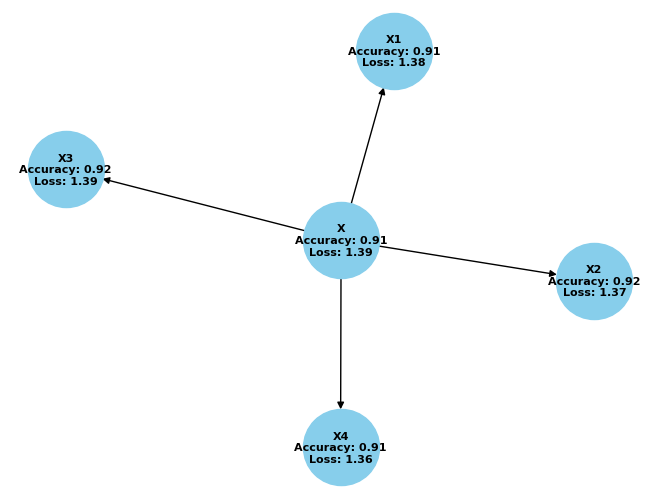

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

def add_nodes_and_edges(graph, parent_node):
    decimal_points = 2
    parent_state = parent_node["State"]
    for child in parent_node["Next States"]:
        child_state = child["State"]
        # Create a label with selected information
        label = f"{child_state}\nAccuracy: {round(child['Accuracy'], decimal_points)}\nLoss: {round(child['Loss'], decimal_points)}"
        graph.add_node(child_state, label=label)
        graph.add_edge(parent_state, child_state)
        add_nodes_and_edges(graph, child)

def plot_tree(tree):
    decimal_points = 2
    G = nx.DiGraph()

    # Add the root node
    root_state = tree["State"]
    root_label = f"{root_state}\nAccuracy: {round(tree['Accuracy'], decimal_points)}\nLoss: {round(tree['Loss'], decimal_points)}"
    G.add_node(root_state, label=root_label)

    # Add children recursively
    add_nodes_and_edges(G, tree)

    # Draw the graph
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, labels=labels, with_labels=True, node_color="skyblue", node_size=3000, font_size=8, font_weight="bold", arrows=True)
    plt.show()
    
plot_tree(root)

I am trying to come up with an algorithm to smartly prune most of the mislabeled data points. I can use any of the prior knowledge I have about how the data got mislabeled. I was thinking of an iterative approach where I start with a model with all data points, calculate accuracy then take a subset from this dataset and recalculate the accuracy. then choose the better accuracy model then repeat until accuracy is >95%. How is that related to any




In [81]:
unique = []

In [82]:
import numpy as np

# Define the array of fruits
fruits = ["apple", "banana", "cherry", "date", "elderberry", "fig", "grape"]

random_fruits = np.random.choice(fruits, 3, replace=False)

[unique.append(fruit) for fruit in random_fruits]

print(random_fruits)

print(unique)

# find if unique is still unique:
print(set(unique))
if len(unique) == len(set(unique)):
    print("Unique is STILL unique")
else:
    print("Unique is NOT unique")


['banana' 'date' 'fig']
['banana', 'date', 'fig']
{'date', 'banana', 'fig'}
Unique is STILL unique
